In [1]:
import pandas as pd
import scanpy as sc
import os
import anndata as ad
import numpy as np
from MulticoreTSNE import MulticoreTSNE as tsne
os.chdir('../')
datasets = pd.read_csv('resources/datasets/meta/filtered_datasets.csv')

In [9]:
# read raw metaset
metaset = sc.read('results/qc/True/scale/False/n_hvg/10000/subset_hvg/False/hvg/True/zero_padding/False/correction_method/skip/perturb_metaset.h5ad')

In [ ]:
sc.pl.tsne(metaset, color=['dataset', 'celltype'], wspace=0.75)

In [ ]:
metaset.obs['is_control'] = (metaset.obs.perturbation=='control') | (metaset.obs.perturbation.str.startswith('3x_neg_ctrl'))
metaset.obs['is_control'] = metaset.obs['is_control'].astype(int)

In [ ]:
sc.pl.pca(metaset, color='is_control')

In [ ]:
p3 = sns.histplot(metaset.obs["total_counts"], bins=100, kde=False)

In [ ]:
metaset.obs['scaled_total_counts'] = np.array(metaset.X.sum(axis=1)).flatten()
sns.histplot(metaset.obs['log1p_total_counts'], bins=100, kde=False)

In [ ]:
# check first PC
pca_loadings = metaset.varm['PCs']
loadings_df = pd.DataFrame(pca_loadings, index=metaset.var_names, columns=[f'PC{i+1}' for i in range(pca_loadings.shape[1])])

In [ ]:
pc1 = loadings_df.iloc[:,0]

In [ ]:
sns.histplot(pc1, bins=100, kde=False)

In [2]:
# read small test datasets
ds1 = sc.read('resources/datasets/data/AdamsonWeissman2016_GSM2406677_10X005.h5ad')
ds2 = sc.read('resources/datasets/data/NormanWeissman2019_filtered.h5ad')
ds_raw = [ds1.copy(), ds2.copy()]
ds_keys = ['AdamsonWeissman2016_GSM2406677_10X005', 'NormanWeissman2019_filtered']
merged = sc.concat(
    ds_raw,
    label='dataset',
    keys=ds_keys
)

In [3]:
print(f'Raw metaset spans: {merged.shape[0]} combined cells and {merged.shape[1]} common genes')
sc.pp.highly_variable_genes(
    merged, n_top_genes=4000, flavor="cell_ranger", batch_key='dataset', subset=True
)
print(f'HVG metaset spans: {merged.shape[0]} combined cells and {merged.shape[1]} common genes')

Raw metaset spans: 106696 combined cells and 30316 common genes


/home/mwe1123/.conda/envs/ExPert/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/mwe1123/.conda/envs/ExPert/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:475: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/mwe1123/.conda/envs/ExPert/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:510: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.highly_variable.iloc[:n_top_genes] = True


HVG metaset spans: 106696 combined cells and 4000 common genes


In [21]:
sc.tl.pca(merged)

In [24]:
pc_var = np.round(merged.uns['pca']['variance_ratio']*100, 2)
print(', '.join([f'PC{i+1}:{v}%' for i, v in enumerate(pc_var[:10])]))

PC1:10.58%, PC2:3.06%, PC3:2.99%, PC4:2.11%, PC5:1.56%, PC6:1.16%, PC7:0.98%, PC8:0.74%, PC9:0.59%, PC10:0.57%


In [35]:
merged.obs['is_control'] = (merged.obs.perturbation=='control') | (merged.obs.perturbation.str.startswith('3x_neg_ctrl'))
merged.obs['control'] = merged.obs['is_control'].apply(lambda x: 'Yes' if x else 'No')

In [26]:
# perform tsne
merged.obsm['X_tsne'] = tsne(n_jobs=10, verbose=1).fit_transform(merged.obsm['X_pca'])

/home/mwe1123/.conda/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/mwe1123/.conda/envs/ExPert/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:364: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


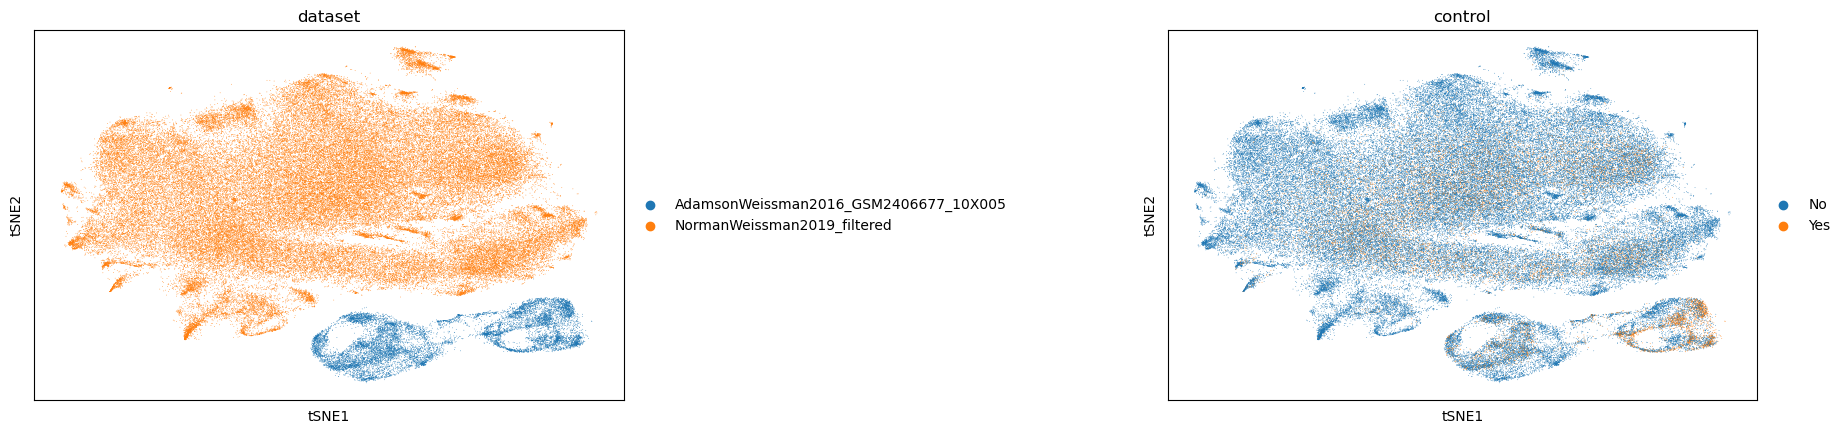

In [40]:
sc.pl.tsne(merged, color=['dataset', 'control'], wspace=0.75)

In [41]:
def _scanorama(ds_list, genes=None):
    # prepare data
    ds_list = [d.copy() for d in ds_list]
    for ds in ds_list:
        if genes is not None:
            ds = ds[:,genes]
        if sp.issparse(ds.X) and not isinstance(ds.X, sp.csr_matrix):
            ds.X = ds.X.tocsr()
    # Perform batch correction using Scanorama
    print('Running scanorama')
    corrected = scanorama.correct_scanpy(ds_list)
    print('Finished scanorama')
    return corrected

In [42]:
ds_list = _scanorama(ds_raw, merged.var_names)

Running scanorama


ERROR: Data sets must be numpy array or scipy.sparse.csr_matrix, received type <class 'scipy.sparse._csc.csc_matrix'>.


SystemExit: 1

In [36]:
corr = ad.concat(ds_list, label='dataset', keys=ds_keys)

In [ ]:
# perform tsne
sc.tl.pca(corr)
corr.obsm['X_tsne'] = tsne(n_jobs=10, verbose=1).fit_transform(corr.obsm['X_pca'])

In [ ]:
corr.obs['is_control'] = (corr.obs.perturbation=='control') | (corr.obs.perturbation.str.startswith('3x_neg_ctrl'))
corr.obs['control'] = corr.obs['is_control'].apply(lambda x: 'Yes' if x else 'No')
sc.pl.tsne(corr, color=['dataset', 'control'], wspace=0.75)